In [55]:
import pandas as pd
data_set = pd.read_csv('employee.csv', encoding='ISO-8859-1')

In [56]:
import numpy as np
# Calcule le nombre de valeurs manquantes selon chaque feature
# fonction old-school, existe certainement une fonction chez pandas...
def compute_missing_values(df):
    list_missing_val = {}
    col = df.columns
    for i, k in enumerate(col):
        list_missing_val[k] = df[k].isna().sum()
    return list_missing_val

In [57]:
df.shape
list = compute_missing_values(data_set)
print("missing values")
for i in list:
    print(f"{i}-->{list[i]:d}")

missing values
NAME-->6
DEPARTMENT_NAME-->6
TITLE-->6
REGULAR-->644
RETRO-->22150
OTHER-->8423
OVERTIME-->15706
INJURED-->21096
DETAIL-->20493
QUINN_EDUCATION_INCENTIVE-->21166
TOTAL_GROSS-->6
POSTAL-->6


In [67]:
# travailler sur une copie pour faire des comparaisons
df = data_set.copy()

# compte le nombre de tuples vides (toutes les features à nan)
# df[df.isna().all(axis=1)].shape[0]

# suppression des tuples vides (toutes les colonnes à NaN)
df = df.dropna(how='all')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22546 entries, 0 to 22545
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   NAME                       22546 non-null  object
 1   DEPARTMENT_NAME            22546 non-null  object
 2   TITLE                      22546 non-null  object
 3   REGULAR                    21908 non-null  object
 4   RETRO                      402 non-null    object
 5   OTHER                      14129 non-null  object
 6   OVERTIME                   6846 non-null   object
 7   INJURED                    1456 non-null   object
 8   DETAIL                     2059 non-null   object
 9   QUINN_EDUCATION_INCENTIVE  1386 non-null   object
 10  TOTAL_GROSS                22546 non-null  object
 11  POSTAL                     22546 non-null  object
dtypes: object(12)
memory usage: 2.2+ MB


In [60]:
col = ['REGULAR', 'RETRO', 'OTHER', 'OVERTIME', 'INJURED', 'DETAIL', 
       'QUINN_EDUCATION_INCENTIVE', 'TOTAL_GROSS', 'POSTAL']
# on remplace les , ' ou tout les trucs qui perturbent la convertion en float python.
df[col] = df[col].replace({',': '', "'": ''}, regex=True)

# on applique la converton en float
df[col] = df[col].apply(pd.to_numeric, errors='coerce')


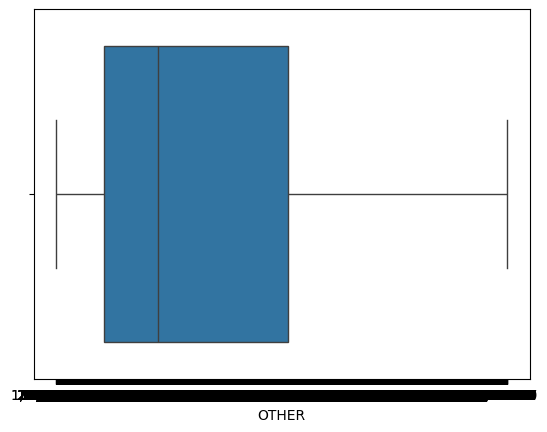

In [71]:
# Recherche d'outliers de manière univariée simple (boxplot vs IQR)

import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x=df['OTHER'])
#sns.boxplot(x=df['TOTAL_GROSS'])

plt.show()


# Specify the two columns you want to visualize
column1 = 'OTHER'  # Replace with the actual column name
column2 = 'TOTAL_GROSS'  # Replace with the actual column name

# Create a figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Boxplot for the first column
sns.boxplot(x=df[column1], ax=axes[0])
axes[0].set_title(f'Boxplot for {column1}')

# Boxplot for the second column
sns.boxplot(x=df[column2], ax=axes[1])
axes[1].set_title(f'Boxplot for {column2}')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

In [68]:
df

,NAME,DEPARTMENT_NAME,TITLE,REGULAR,RETRO,OTHER,OVERTIME,INJURED,DETAIL,QUINN_EDUCATION_INCENTIVE,TOTAL_GROSS,POSTAL
0,"Beckers,Richard",Boston Police Department,Police Officer,NaN,NaN,"1,264,843.63",NaN,NaN,NaN,NaN,"1,264,843.63",02119
1,"McGowan,Jacqueline M.",Boston Police Department,Police Officer,NaN,NaN,"1,252,990.81",NaN,NaN,NaN,NaN,"1,252,990.81",02129
2,"Harris,Shawn N",Boston Police Department,Police Offc Comm Serv Offc 3$8,"69,772.10",NaN,"212,739.48","82,300.87","30,939.24","12,144.00","25,178.06","433,073.75",02130
3,"Washington,Walter",Boston Police Department,Police Officer,"100,963.38",NaN,"211,900.28","67,849.66",NaN,"9,016.00","10,096.55","399,825.87",02368
4,"Mosley Jr.,Curtis",Boston Police Department,Police Offc Comm Serv Offc 3$8,"109,858.02",NaN,"192,097.54","75,938.65",NaN,"19,550.00",NaN,"397,444.21",02301
...,...,...,...,...,...,...,...,...,...,...,...,...
22541,"Bartholomew,Joseph William",BPS Special Education,Assistant Director,NaN,69.86,NaN,NaN,NaN,NaN,NaN,69.86,02131
22542,"Rabouin,Shante Evelin",BPS Substitute Teachers/Nurs,Substitute Teacher,NaN,NaN,NaN,59.78,NaN,NaN,NaN,59.78,02180
22543,"Francisco,Carla E",Tech Boston Academy,Part-Time Cafeteria Attendant,NaN,NaN,56.62,NaN,NaN,NaN,NaN,56.62,02121
22544,"Ellis,Nicole L",Food & Nutrition Svc,Substitute Cafeteria Attendant,54.00,NaN,NaN,NaN,NaN,NaN,NaN,54.00,02111


# Rapport

## Q2:
- La commande count() nous permet de connaître le nombre de tuple pour chaque feature. Nous avons 22546 enregistrements et 12
  colonnes (features).
- La fonction codée plus haut nous permet de connaître le nombre de valeurs manquantes. En voici la sortie:
  missing values
NAME-->6
DEPARTMENT_NAME-->6
TITLE-->6
REGULAR-->644
RETRO-->22150
OTHER-->8423
OVERTIME-->15706
INJURED-->21096
DETAIL-->20493
QUINN_EDUCATION_INCENTIVE-->21166
TOTA
POSTAL-->6
L_GROSS-->6
- Oui il y 6 tuples dont toutes les colonness
POSTAL-->6





